# Causal Learning

## Imports

In [ ]:
!git clone https://github.com/Gio99c/Causal-Discovery-Algorithms-on-Medical-Data.git

Cloning into 'Causal-Discovery-Algorithms-on-Medical-Data'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 8), reused 14 (delta 3), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [ ]:
!git clone https://github.com/10-Academy-quad-squad/casual-graph.git

Cloning into 'casual-graph'...
remote: Enumerating objects: 705, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 705 (delta 24), reused 21 (delta 21), pack-reused 620
Receiving objects: 100% (705/705), 47.96 MiB | 14.18 MiB/s, done.
Resolving deltas: 100% (344/344), done.


In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install causalnex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from causalnex.discretiser import Discretiser
from causalnex.structure import DAGRegressor
from causalnex.inference import InferenceEngine
from causalnex.network import BayesianNetwork
from causalnex.network.sklearn import BayesianNetworkClassifier
from causalnex.structure.notears import from_pandas
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas, from_pandas_lasso
from causalnex.discretiser.discretiser_strategy import ( DecisionTreeSupervisedDiscretiserMethod )

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score, precision_score

In [ ]:
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('/content/casual-graph/scripts')))

In [ ]:
# from file_handler import FileHandler
import pandas as pd
import vis_seaborn as vs
from eda_helper import Helper
from df_overview import DfOverview
from ScalerNormalizer import ScalerNormalizer

In [ ]:
helper = Helper()
sn = ScalerNormalizer()

## Data reading

In [ ]:
# fh = FileHandler()
df = pd.read_csv("/content/Causal-Discovery-Algorithms-on-Medical-Data/datasets/thyroid.csv")
df.head(5)

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
0,41,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.3,t,2.5,t,125,t,1.14,t,109,f,?,SVHC,P
1,23,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.1,t,2,t,102,f,?,f,?,f,?,other,P
2,46,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,?,t,109,t,0.91,t,120,f,?,other,P
3,70,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175,f,?,f,?,f,?,other,P
4,70,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61,t,0.87,t,70,f,?,SVI,P


In [ ]:
feat = list(df.columns)

In [ ]:
len(feat)

30

In [ ]:
# Binarize textual data
df.replace({'F': 0., 'f': 0., 'M': 1., 't': 1., "P": 1., "N": 0.}, inplace=True)

# Categorical encoding for "referreal source" column
df.replace({'SVHC': 0, 'SVI': 1, 'STMW': 2, 'SVHD': 3, 'other': -1}, inplace=True)

# "?" values have to removed. They cannot be mapped to np.nan because the algorithm won't work. I decided to map those values to 0, but we should discuss this choice
df.replace({'?': 0.}, inplace=True)

# There are no measurements for TBG, can be dropped
df.drop(columns=["TBG", "TBG measured"], inplace=True)

In [ ]:
# feat = ['diagnosis', 'perimeter_worst', 'area_worst', 'radius_worst', 'concave points_worst', 'concave points_mean', 'perimeter_mean', 'area_mean', 'radius_mean', 'area_se', 'concavity_mean', 'concavity_worst', 'perimeter_se', 'radius_se', 'compactness_worst', 'compactness_mean', 'texture_worst', 'concave points_se', 'smoothness_worst', 'texture_mean', 'symmetry_worst', 'concavity_se', 'smoothness_mean', 'symmetry_mean', 'compactness_se', 'fractal_dimension_worst', 'fractal_dimension_se', 'texture_se', 'fractal_dimension_mean', 'symmetry_se', 'smoothness_se']

In [ ]:
df.rename(columns = {"binaryClass":"diagnosis"},inplace=True)

In [ ]:
x = df
# x['binaryClass'] = x['binaryClass'].apply(lambda x: 1 if x == "M" else 0)
# x.head(5)

In [ ]:
x.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,referral source,diagnosis
0,41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.3,1.00,2.5,1.00,125,1.00,1.14,1.00,109,0,1.00
1,23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,4.1,1.00,2,1.00,102,0.00,0.00,0.00,0.00,-1,1.00
2,46,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.98,0.00,0.00,1.00,109,1.00,0.91,1.00,120,-1,1.00
3,70,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.16,1.00,1.9,1.00,175,0.00,0.00,0.00,0.00,-1,1.00
4,70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.72,1.00,1.2,1.00,61,1.00,0.87,1.00,70,1,1.00


In [ ]:
x.shape[1]-1


27

In [ ]:
# num_feat = x.shape[1]-1
# fig = plt.figure(figsize=(27, num_feat))
# fig.subplots_adjust(hspace=.5)
# axs = [fig.add_subplot(num_feat / 4, 4, i + 1) for i in range(num_feat)]

# for i, column in enumerate(x.columns[1:]):
#     sns.distplot(x[x.diagnosis == 1][column], ax=axs[i], color='darkorange', label="M")
#     sns.distplot(x[x.diagnosis == 0][column], ax=axs[i], color='darkgreen', label="B")
#     axs[i].set_title('Distribution for {}'.format( column), fontweight='bold', fontsize=15)
#     axs[i].legend(fontsize=20)
# plt.show()

## Normalize the data

In [ ]:
features = x.iloc[:, :27]
features

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,referral source
0,41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.3,1.00,2.5,1.00,125,1.00,1.14,1.00,109,0
1,23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,4.1,1.00,2,1.00,102,0.00,0.00,0.00,0.00,-1
2,46,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.98,0.00,0.00,1.00,109,1.00,0.91,1.00,120,-1
3,70,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.16,1.00,1.9,1.00,175,0.00,0.00,0.00,0.00,-1
4,70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.72,1.00,1.2,1.00,61,1.00,0.87,1.00,70,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1
3768,68,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1,1.00,2.1,1.00,124,1.00,1.08,1.00,114,1
3769,74,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,5.1,1.00,1.8,1.00,112,1.00,1.07,1.00,105,-1
3770,72,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.7,1.00,2,1.00,82,1.00,0.94,1.00,87,1


In [ ]:
normal_data = sn.scale_and_normalize(features, features.columns.to_list())
normal_data.insert(loc=0, column='diagnosis', value=x['diagnosis'])
normal_data

,diagnosis,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,referral source
0,1.00,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.00,0.43,0.10,0.43,0.12,0.43,0.21,0.43,0.12,0.11
1,1.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.57,0.00,0.57,0.11,0.57,0.13,0.00,0.00,0.00,0.00,0.00
2,1.00,0.04,0.43,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.00,0.00,0.00,0.43,0.11,0.43,0.17,0.43,0.13,0.00
3,1.00,0.07,0.00,0.49,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.49,0.00,0.49,0.09,0.49,0.20,0.00,0.00,0.00,0.00,0.00
4,1.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.43,0.00,0.43,0.05,0.43,0.06,0.43,0.16,0.43,0.08,0.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,1.00,0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3768,1.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.42,0.00,0.42,0.08,0.42,0.12,0.42,0.20,0.42,0.12,0.21
3769,1.00,0.06,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.40,0.00,0.00,0.00,0.00,0.00,0.40,0.00,0.40,0.07,0.40,0.10,0.40,0.18,0.40,0.11,0.00
3770,1.00,0.06,0.39,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.39,0.00,0.39,0.07,0.39,0.07,0.39,0.16,0.39,0.09,0.20


In [ ]:
%%time
sm = from_pandas(normal_data.iloc[:, :9], tabu_parent_nodes=['diagnosis'],)

CPU times: user 1e+03 ms, sys: 1.73 s, total: 2.73 s
Wall time: 1.46 s


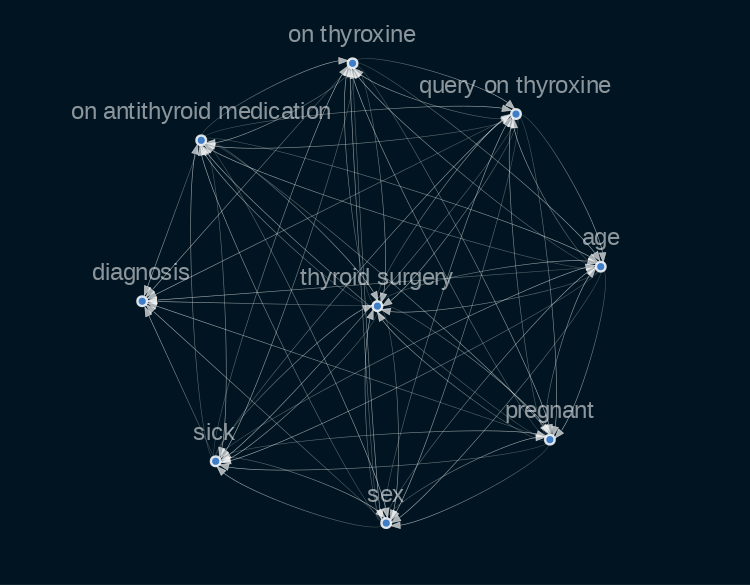

In [ ]:
vs.vis_sm(sm)

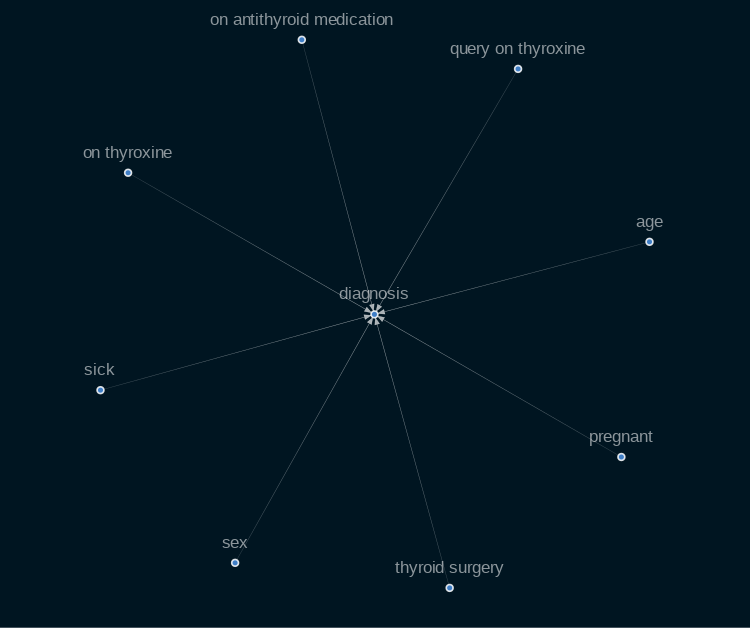

In [ ]:
sm.remove_edges_below_threshold(0.8)
vs.vis_sm(sm)

## Stablity of causal graph


In [ ]:
x_selected = normal_data.iloc[:, :10]

### 50%

In [ ]:
portion = int(x_selected.shape[0] *.5)
x_portion = x_selected.head(portion)

CPU times: user 744 ms, sys: 1.05 s, total: 1.79 s
Wall time: 1.04 s


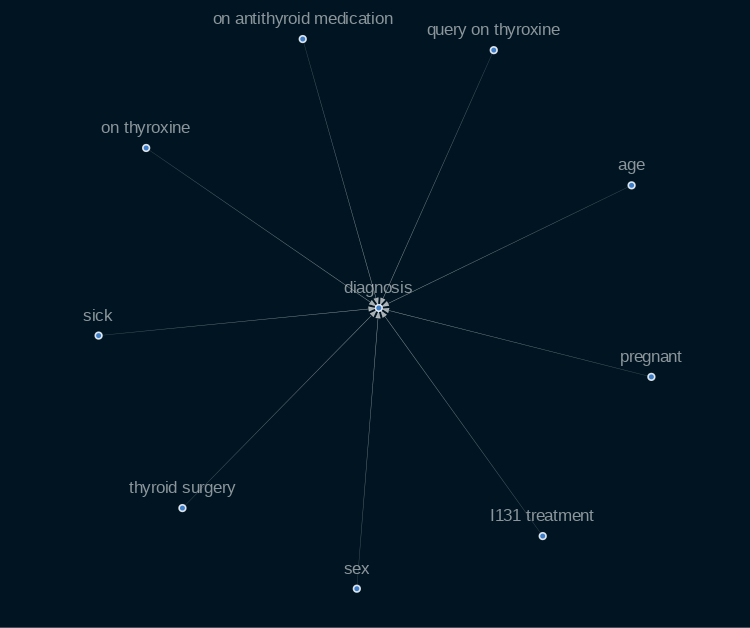

In [ ]:
%%time
sm1 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm1.remove_edges_below_threshold(0.8)
sm1 = sm1.get_largest_subgraph()
vs.vis_sm(sm1)

In [ ]:
print(sm1.edges)

[('age', 'diagnosis'), ('sex', 'diagnosis'), ('on thyroxine', 'diagnosis'), ('query on thyroxine', 'diagnosis'), ('on antithyroid medication', 'diagnosis'), ('sick', 'diagnosis'), ('pregnant', 'diagnosis'), ('thyroid surgery', 'diagnosis'), ('I131 treatment', 'diagnosis')]


# 60%

In [ ]:
portion = int(x_selected.shape[0]*.6)
x_portion = x_selected.head(portion)

CPU times: user 1.13 s, sys: 1.46 s, total: 2.6 s
Wall time: 2.85 s


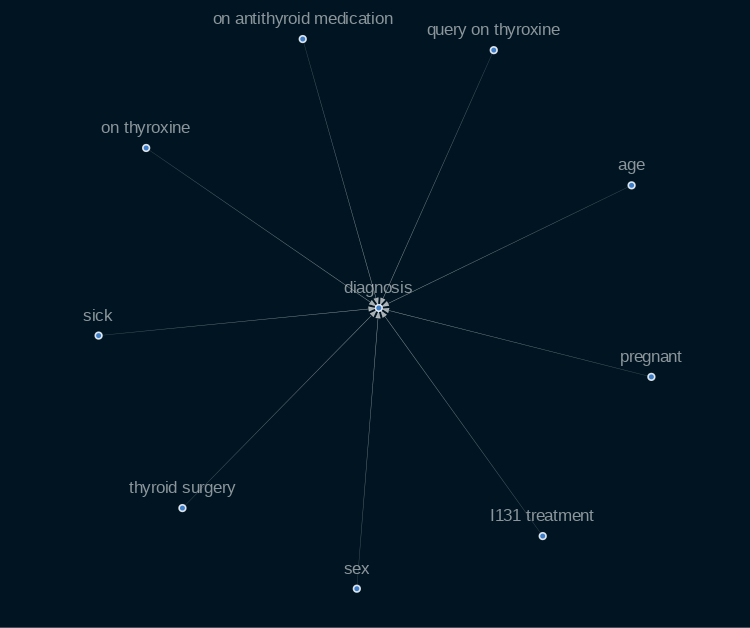

In [ ]:
%%time
sm2 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm2.remove_edges_below_threshold(0.8)
sm2 = sm2.get_largest_subgraph()
vs.vis_sm(sm2)

In [ ]:
def jaccard_similarity(g, h):
    i = set(g).intersection(h)
    return round(len(i) / (len(g) + len(h) - len(i)), 3)

In [ ]:
jaccard_similarity(sm1.edges, sm2.edges)

1.0

# 70%

In [ ]:
portion = int(x_selected.shape[0]*.7)
x_portion = x_selected.head(portion)

CPU times: user 836 ms, sys: 988 ms, total: 1.82 s
Wall time: 1.05 s


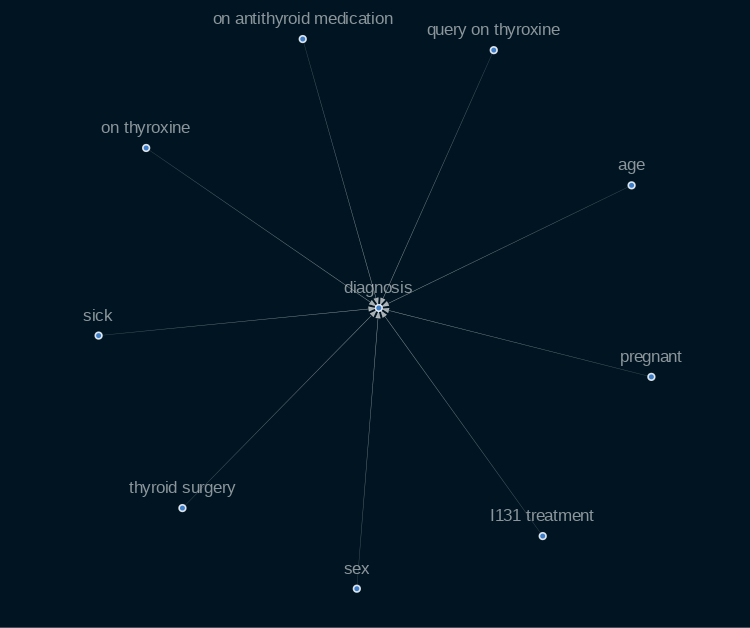

In [ ]:
%%time
sm3 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm3.remove_edges_below_threshold(0.8)
sm3 = sm3.get_largest_subgraph()
vs.vis_sm(sm3)

In [ ]:
jaccard_similarity(sm2.edges, sm3.edges)

1.0

# 80%

In [ ]:
portion = int(x_selected.shape[0] * .8)
x_portion = x_selected.head(portion)

CPU times: user 913 ms, sys: 1.33 s, total: 2.24 s
Wall time: 1.26 s


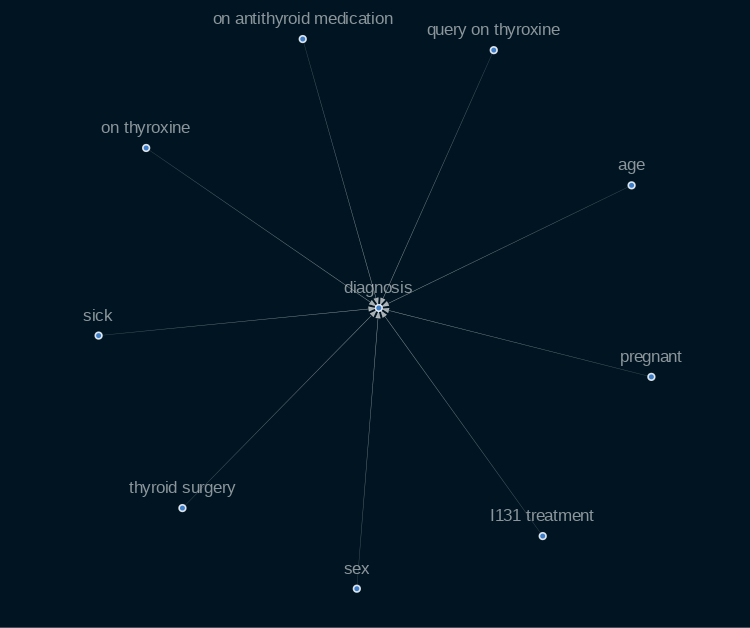

In [ ]:
%%time
sm4 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm4.remove_edges_below_threshold(0.8)
sm4 = sm4.get_largest_subgraph()
vs.vis_sm(sm4)

In [ ]:
jaccard_similarity(sm3.edges, sm4.edges)

1.0

# 90%

In [ ]:
portion = int(x_selected.shape[0] * .9)
x_portion = x_selected.head(portion)

CPU times: user 1.1 s, sys: 1.64 s, total: 2.74 s
Wall time: 1.53 s


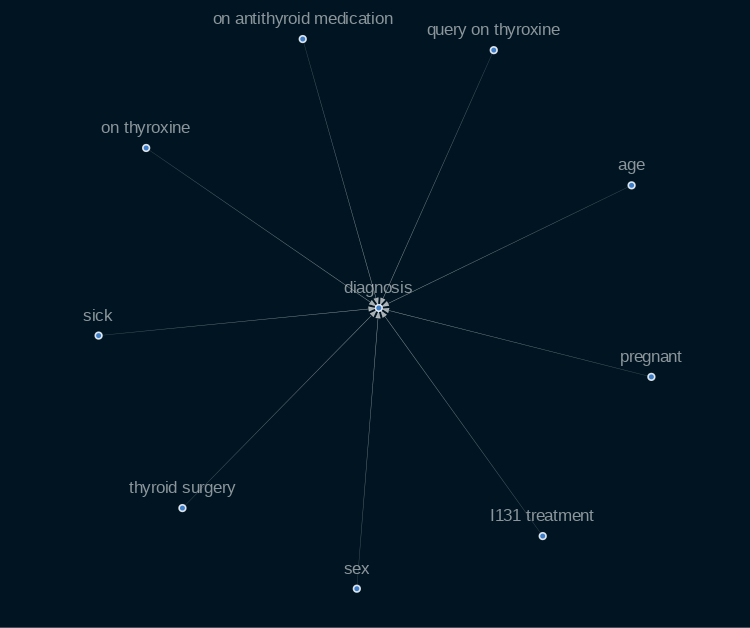

In [ ]:

%%time
sm5 = from_pandas(x_portion, tabu_parent_nodes=['diagnosis'],)
sm5.remove_edges_below_threshold(0.8)
sm5 = sm5.get_largest_subgraph()
vs.vis_sm(sm5)

In [ ]:


# Casual Inference model for breast cancer

In [ ]:
jaccard_similarity(sm5.edges, sm4.edges)

1.0

# 100%

CPU times: user 1.17 s, sys: 1.92 s, total: 3.09 s
Wall time: 1.71 s


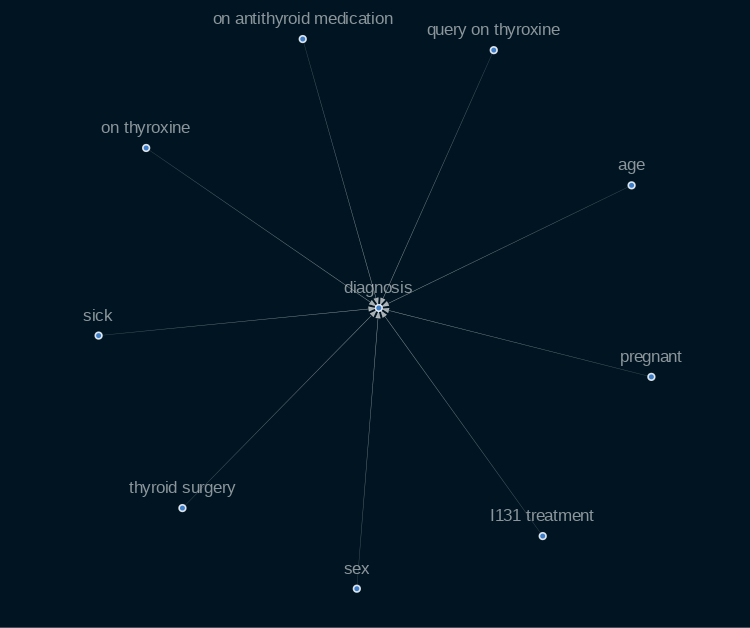

In [ ]:

%%time
sm = from_pandas(x_selected, tabu_parent_nodes=['diagnosis'],)
sm.remove_edges_below_threshold(0.8)
sm = sm.get_largest_subgraph()
vs.vis_sm(sm)

In [ ]:
jaccard_similarity(sm.edges, sm5.edges)

1.0

## Reducing a graph to its Markov Blanket

Now, assume that target is our variable of interest. We actually do not need all the nodes in the network but only the MB of target. To achieve that, we simply need to use the get_markov_blanket function from causalnex. Specifically,

In [ ]:
bn = BayesianNetwork(sm)
# blanket = StructureModel.get_markov_blanket(bn, 'diagnosis')
# edge_list = list(blanket.structure.edges)
# edge_list

In [ ]:
# vs.vis_sm(blanket.structure)

## Discretising Numeric Features

In [ ]:
x

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH measured,TSH,T3 measured,T3,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,referral source,diagnosis
0,41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.3,1.00,2.5,1.00,125,1.00,1.14,1.00,109,0,1.00
1,23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,4.1,1.00,2,1.00,102,0.00,0.00,0.00,0.00,-1,1.00
2,46,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.98,0.00,0.00,1.00,109,1.00,0.91,1.00,120,-1,1.00
3,70,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.16,1.00,1.9,1.00,175,0.00,0.00,0.00,0.00,-1,1.00
4,70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.72,1.00,1.2,1.00,61,1.00,0.87,1.00,70,1,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1,1.00
3768,68,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1,1.00,2.1,1.00,124,1.00,1.08,1.00,114,1,1.00
3769,74,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,5.1,1.00,1.8,1.00,112,1.00,1.07,1.00,105,-1,1.00
3770,72,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.7,1.00,2,1.00,82,1.00,0.94,1.00,87,1,1.00


In [ ]:
x_selected = x.iloc[:, [0,1,2,3,4,5,6,7,8,9,10, -1]]
x_selected

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,query hyperthyroid,diagnosis
0,41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
1,23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,46,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3,70,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
4,70,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3768,68,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3769,74,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00
3770,72,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [ ]:
df_overview = DfOverview(x_selected)
overview = df_overview.getOverview()
vs.view_df(overview[["count", "unique_value_count", "unique_percentage"]],
                    ["count", "unique_value_count"])

,label,count,unique_value_count,unique_percentage
0,AGE,3772,94,2.49%
1,SEX,3772,2,0.05%
2,ON THYROXINE,3772,2,0.05%
3,QUERY ON THYROXINE,3772,2,0.05%
4,ON ANTITHYROID MEDICATION,3772,2,0.05%
5,SICK,3772,2,0.05%
6,PREGNANT,3772,2,0.05%
7,THYROID SURGERY,3772,2,0.05%
8,I131 TREATMENT,3772,2,0.05%
9,QUERY HYPOTHYROID,3772,2,0.05%


In [ ]:
features = list(x_selected.columns.difference(['diagnosis']))
features

['I131 treatment',
 'age',
 'on antithyroid medication',
 'on thyroxine',
 'pregnant',
 'query hyperthyroid',
 'query hypothyroid',
 'query on thyroxine',
 'sex',
 'sick',
 'thyroid surgery']

In [ ]:
tree_discretiser = DecisionTreeSupervisedDiscretiserMethod(
    mode='single',
    tree_params={'max_depth': 3, 'random_state': 27},
)
tree_discretiser.fit(
    feat_names=features,
    dataframe=x,
    target_continuous=True,
    target='diagnosis',
)
tree_discretiser

DecisionTreeSupervisedDiscretiserMethod(tree_params={'max_depth': 3,
                                                     'random_state': 27})

In [ ]:
x_selected['age'] = x_selected['age'].astype(int)
discretised_data = x_selected.copy()
# discretised_data['age'] = discretised_data['age'].astype(int)
for col in features:
    discretised_data[col] = tree_discretiser.transform(x_selected[[col]])
discretised_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        3772 non-null   int64  
 1   sex                        3772 non-null   int64  
 2   on thyroxine               3772 non-null   int64  
 3   query on thyroxine         3772 non-null   int64  
 4   on antithyroid medication  3772 non-null   int64  
 5   sick                       3772 non-null   int64  
 6   pregnant                   3772 non-null   int64  
 7   thyroid surgery            3772 non-null   int64  
 8   I131 treatment             3772 non-null   int64  
 9   query hypothyroid          3772 non-null   int64  
 10  query hyperthyroid         3772 non-null   int64  
 11  diagnosis                  3772 non-null   float64
dtypes: float64(1), int64(11)
memory usage: 353.8 KB


In [ ]:
df_overview = DfOverview(discretised_data)
overview = df_overview.getOverview()
vs.view_df(overview[["count", "unique_value_count", "unique_percentage"]],
           ["count", "unique_value_count"])

,label,count,unique_value_count,unique_percentage
0,AGE,3772,8,0.21%
1,SEX,3772,2,0.05%
2,ON THYROXINE,3772,2,0.05%
3,QUERY ON THYROXINE,3772,2,0.05%
4,ON ANTITHYROID MEDICATION,3772,2,0.05%
5,SICK,3772,2,0.05%
6,PREGNANT,3772,2,0.05%
7,THYROID SURGERY,3772,2,0.05%
8,I131 TREATMENT,3772,2,0.05%
9,QUERY HYPOTHYROID,3772,2,0.05%


## Train Test Split

In [ ]:
train, test = train_test_split( discretised_data, train_size=0.8, test_size=0.2, random_state=27)

## Bayesian Network

In [ ]:
# bn = BayesianNetwork(blanket.structure)
bn = bn.fit_node_states(discretised_data)
bn = bn.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")

In [ ]:
pred = bn.predict(test, 'diagnosis')
true = test['diagnosis']
pred

,diagnosis_prediction
578,1.00
1725,1.00
3191,1.00
3235,1.00
1850,1.00
...,...
1560,1.00
785,1.00
156,1.00
1810,1.00


In [ ]:
print('Recall: {:.2f}'.format(recall_score(y_true=true, y_pred=pred)))
print('F1: {:.2f} '.format(f1_score(y_true=true, y_pred=pred)))
print('Accuracy: {:.2f} '.format(accuracy_score(y_true=true, y_pred=pred)))
print('Precision: {:.2f} '.format(precision_score(y_true=true, y_pred=pred)))

Recall: 0.99
F1: 0.95 
Accuracy: 0.91 
Precision: 0.91 


In [ ]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn, test, "diagnosis")
print(auc)

0.9290259199157931


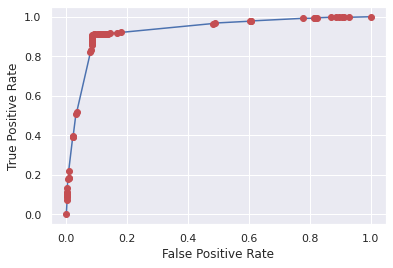

In [ ]:
fpr = [x[0] for x in roc]
tpr = [x[1] for x in roc]

plt.plot(fpr,tpr)
plt.plot(fpr,tpr,'or')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:

from causalnex.evaluation import classification_report
classification_report(bn, test, "diagnosis")

{'diagnosis_0.0': {'precision': 0.3333333333333333,
  'recall': 0.029850746268656716,
  'f1-score': 0.05479452054794521,
  'support': 67},
 'diagnosis_1.0': {'precision': 0.9132176234979973,
  'recall': 0.9941860465116279,
  'f1-score': 0.9519832985386222,
  'support': 688},
 'accuracy': 0.9086092715231788,
 'macro avg': {'precision': 0.6232754784156653,
  'recall': 0.5120183963901423,
  'f1-score': 0.5033889095432837,
  'support': 755},
 'weighted avg': {'precision': 0.8617576931125238,
  'recall': 0.9086092715231788,
  'f1-score': 0.87236522155137,
  'support': 755}}